# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary classifier.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title, and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use a random forest classifier, as well as another classifier of your choice; either logistic regression, SVM, or KNN. 

- **Question**: Why would we want this to be a classification problem?
- **Answer**: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Set up a request (using requests) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)
The URL here has many query parameters
- q for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- l for a location
- start for what result number to start on

In [353]:
URL = "https://www.indeed.com/jobs?q=Data+Scientist&l=Washington%2C+DC"


In [3]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib as plt
import seaborn as sns
import scipy.stats as stats
plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
html = requests.get(URL)
soup = BeautifulSoup(html.text, 'html.parser', from_encoding="utf-8")
# soup = BeautifulSoup(html.text)
print soup.prettify()

Let's look at one result more closely. A single result looks like
```JSON
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&campaignid=serp-linkcompanyname&fromjk=2480d203f7e97210&jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a nobr element inside of a td element with class='snip.
- The title of a job is in a link with class set to jobtitle and a data-tn-element="jobTitle.
- The location is set in a span with class='location'.
- The company is set in a span with class='company'.

## Write 4 functions to extract these items (one function for each): location, company, job title, and salary.¶
Example
```python
def extract_location_from_result(result):
    return result.find ...
```

##### - Make sure these functions are robust and can handle cases where the data/field may not be available.
>- Remember to check if a field is empty or None for attempting to call methods on it
>- Remember to use try/except if you anticipate errors.

- **Test** the functions on the results above and simple examples

In [ ]:
### First cell was my drydock for building the larger scraper. I answer all question/requirementes with this function
## but I included a different example below on how to get the same data.
def jobscrapper(city):
    urlcity = city.replace(" ", "%2C+")
    
    home_url = 'https://www.indeed.com/jobs?q=Data+Scientist&l='
    
    html = requests.get(home_url+urlcity)
    soup = BeautifulSoup(html.text, 'html.parser', from_encoding="utf-8")

    dftest = pd.DataFrame()
#     df.columns["Title", 'Location', 'Salary', 'Company']
    rows= []


    
    for i in soup.find_all(class_=' row result'):
        try:
            title= i.find(class_="jobtitle").text.replace('\n', '')
        except:
            title= np.nan
        try:
            location = i.find(class_='location').text.replace('\n', '')
        except:
            location= np.nan
        try:
            company = i.find(class_='company').text.replace('\n', '')
        except:
            company= np.nan
        try:
            salary = i.find(class_='no-wrap').text
        except:
            salary = np.nan
#             company = m.text
#         df.append('jobtitle':title, 'location':location, 'company':company)
#         df= df.append({'Title': title, "Location": location, "Salary": salary, "Company": company}, ignore_index=True)
        dftest= dftest.append({'title': title, 'location': location, 'salary': salary, 'company': company}, ignore_index=True)

    print dftest.head(10)
jobscrapper("new york")

In [ ]:
## Example that I know how to do it the 'other' way
def extract_loc_from_result(result):
    locations=[]
    for i in result.find_all(class_="jobtitle"): 
        locations.append(i.text.replace('\n', ''))
    return locations
    
extract_loc_from_result(soup)


Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.
- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the l=New+York and the start=10. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).
##### Complete the following code to collect results from multiple cities and starting points.
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [ ]:
YOUR_CITY = 'Washington+DC'

In [ ]:
#I made no changes in this cell
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 100 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        # Append to the full set of results
        pass

In [ ]:
## The final product scraper
# First we set up the url template, maximum amount of pages per city searched (1 page = 10 units), instantiate the panda frame where everything is going
url_template = 'https://www.indeed.com/jobs?q=Data+Scientist&l='
max_results_per_city = 3500
df= pd.DataFrame()

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'Washington+DC', 'Tampa+Bay', 'Orlando', 'San+Diego', 'Pasadena', 'Cleveland', 
    'Sacramento', 'New+Orleans', 'San+Antonio', 'Palm+Springs', 'Newark', 
    'Connecticut', 'Wilmington', 'Charlotte', 'Nashville', 'Oklahoma+City', 'Minneapolis', 'San+Jose', 'Jacksonville', 'Columbus', 'Ft.+Worth', 'El+Paso', 
    'Memphis', 'Baltimore', 'Las+Vegas', 'Milwaukee', 'Tucson', 
    'Kansas+City', 'Colorado+Springs', 'Raleigh', 'Arlington', 'Honolulu', 'Cincinnati', 'Omaha', 'Long+Beach', 'Louiseville', 'Virginia+Beach', 'albuquerque', 'Albuquerque', 'Tulsa', 'Detroit', 
    'Mesa', 'Fresno', 'Oakland', 'Wichita', 'Bakersfield', 
    'Anaheim', 'Santa+Ana', 'Corpus+Christi', 'Riverside', 'Lexington', 'Saint+Paul', 'Greensboro', 'Plano', 'Lincoln', 'Toledo', 'Durham', 'Norfolk', 'Richmond', 'Des+Moines', 'Little+Rock', 'Grand+Rapids']):
    for start in range(0, max_results_per_city, 10):        ## Generates numbers from 0 in 10s increment to satisfy indeed url syntax/format
        html = requests.get(url_template+city+"&start="+str(start))   ## Connects the base url_template with the city the scraper is looking at, another format element, then the number generated in the previous line
        soup = BeautifulSoup(html.text, 'html.parser', from_encoding="utf-8")  ##Yummy soup ready to yield meaty data
        for i in soup.find_all(class_=' row result'):         ## I point the scraper to only look at job entry blocks
            try:
                title= i.find(class_="jobtitle").text.replace('\n', '')   ##subset to look for job title inside of job entry block
            except:
                title= np.nan                                             ## Built in option for missing values and/or continue working through an error
            try:
                location = i.find(class_='location').text.replace('\n', '') ## Rinse, repeat for all other elements inside of job entry block we want
            except:
                location= np.nan
            try:
                company = i.find(class_='company').text.replace('\n', '')
            except:
                company= np.nan
            try:
                salary = i.find(class_='no-wrap').text
            except:
                salary = np.nan
            try:
                summary = i.find(class_='summary').text.replace('\n', '')
            except:
                summary = np.nan
           ## Time to append to the dataframe we instatiated before starting the loop
            df= df.append({'title': title, 'location': location, 'salary': salary, 'company': company, 'summary': summary}, ignore_index=True)
print df.shape  ## Check hits before I start EDA

In [3]:
## Handy dandy EDA block that catches most problems. Will be used in next cell.
def eda(dataframe):
    print "missing values \n", dataframe.isnull().sum()
    print "dataframe index \n", dataframe.index
    print "dataframe types \n", dataframe.dtypes
    print "dataframe shape \n", dataframe.shape
    print "dataframe describe \n", dataframe.describe()
    print "dataframe duplicates \n", dataframe.duplicated().sum() 
    for item in dataframe:
        print item
        print dataframe[item].nunique()

In [ ]:
cleandf = df.drop_duplicates()
cleandf = cleandf.dropna(subset = ['salary'])  #entries without salary data are not useful for our purposes
eda(cleandf)

In [ ]:
df.to_csv('/Users/andresgonzalez/Desktop/GA/curriculum/project_3/datafinal.csv', encoding='utf-8')  # Save copy jic

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [ ]:
## I made a one stop scraper that saves those fields, plus summary, to a panda frame. Please see above.

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now
1. Some of the entries may be duplicated
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries

In [ ]:
## I performed this action above, so I wont be running this cell
cleandf = df.drop_duplicates()
cleandf = cleandf.dropna(subset = ['salary'])  #entries without salary data are not useful for our purposes, kept the hourly, daily, and weekly data because I can transform it into something useable
eda(cleandf)

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [ ]:
for i in cleandf.salary:
    i.replace('\n', '')

In [6]:
import re

# made a regex dependent function that looks for either two sets of numbers, or one number. Either way it tries to get the average of the two.
# The function also removes the comas in the numbers and sets them as floats
# Repeats the process for months/weekly/daily salary posting, then converts them to a yearly basis
def salary_to_float(string):
    if re.findall('(.*) a year', string):
        salinter = re.findall('([0-9]+,[0-9]+|[0-9]+)', string)
        salinter = np.mean([float(i.replace(',', '')) for i in salinter])
        return salinter
        
    elif re.findall('(.*) a month', string):
        salinter = re.findall('([0-9]+,[0-9]+|[0-9]+)', string)
        salinter = np.mean([float(i.replace(',', '')) for i in salinter])*12
        return salinter
    
    elif re.findall('(.*) a week', string):
        salinter = re.findall('([0-9]+,[0-9]+|[0-9]+)', string)
        salinter = np.mean([float(i.replace(',', '')) for i in salinter])*52
        return salinter
    
    elif re.findall('(.*) a day', string):
        salinter = re.findall('([0-9]+,[0-9]+|[0-9]+)', string)
        salinter = np.mean([float(i.replace(',', '')) for i in salinter])*5*52
        return salinter
    
    elif re.findall('(.*) an hour', string):
        salinter = re.findall('([0-9]+\.[0-9]+|[0-9]+)', string)
        salinter = np.mean([float(i.replace(',', '')) for i in salinter])*40*52
        return salinter
    else:
        return np.nan

# new_data = cleandf[cleandf.salary.apply(salary_to_float)]
# cleandf['float_salary'] = new_data


In [ ]:
new_data = cleandf.salary.apply(salary_to_float)
cleandf['float_salary'] = new_data

In [ ]:
cleandf.head()

### Save your results as a CSV

In [ ]:
# Export to csv
cleandf.to_csv('/Users/andresgonzalez/Desktop/GA/curriculum/project_3/datafinal.csv', encoding='utf-8')  # Save copy jic

## Predicting salaries using Random Forests + Another Classifier

#### Load in the the data of scraped salaries

In [4]:
data = pd.read_csv('/Users/andresgonzalez/Desktop/GA/curriculum/Project_3/data1.csv') 

In [7]:
new_data = data.salary.apply(salary_to_float)
data['float_salary'] = new_data

In [8]:
# Function to look at location series and take out state by referencing 2 consecutive capital letters
def findstate(string):
        return re.findall('([A-Z][A-Z])', string)
    
new_state = data.location.apply(findstate)
data['state']= new_state

In [9]:
# The yield of the previous cell was a list, so i made a simple de-lister
def dlist(lister):
    return lister[0]

data['state'] = data.state.apply(dlist)

In [59]:
data.head()

,Unnamed: 0,company,location,salary,title,float_salary,state
0,0,MD Anderson Cancer Center,"Houston, TX","$76,400 - $114,600 a year",Computational Scientist,95500.0,TX
1,20,Rice University,"Houston, TX","$40,800 - $79,100 a year",Research Scientist,59950.0,TX
2,24,Baylor College of Medicine,"Houston, TX","$43,794 a year",Quality Assurance Analyst (Research),43794.0,TX
3,25,MD Anderson Cancer Center,"Houston, TX","$66,400 - $99,600 a year",Research Statistical Analyst - Biostatistics,83000.0,TX
4,26,MD Anderson Cancer Center,"Houston, TX","$66,400 - $99,600 a year",Research Statistical Analyst,83000.0,TX


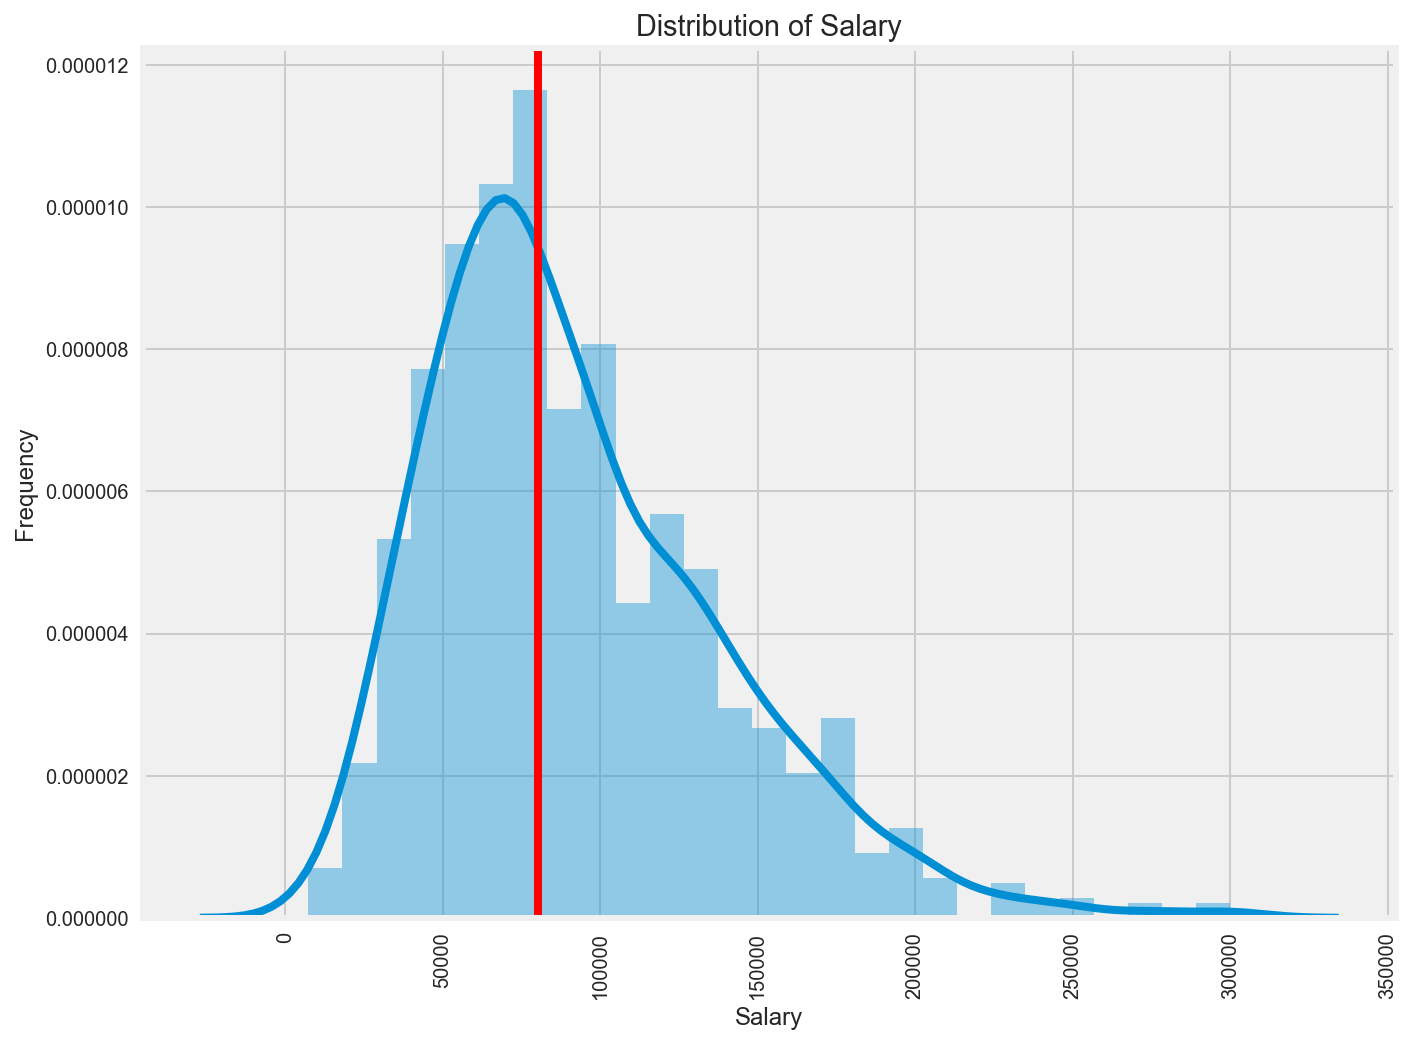

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
## Visualization to show why I used median over mean: Mean makes for a more extreme 
## judge of high/low, perhaps unfairly due to outliers. I know, I know, RF is non-parametric, but
## I'm not planning on being hazy about how useless this is for resolving this class. problem
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(data.float_salary)
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Distribution of Salary')
plt.axvline(x=median, color='r')
# plt.axvline(x=mean, color='g')
plt.show()
# If you have issues running this plot, make sure you run the following code cell first

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries, 

In [11]:
median = np.median(data['float_salary'])
mean = np.mean(data['float_salary'])
mean

92254.08363774735

In [62]:
median

80395.25

In [14]:
data['salaryovermedian'] = np.where(data['float_salary'] > median, 1,0) #converting salary into a binary above median/below median

In [64]:
data.head(2)

,Unnamed: 0,company,location,salary,title,float_salary,state,salaryovermedian
0,0,MD Anderson Cancer Center,"Houston, TX","$76,400 - $114,600 a year",Computational Scientist,95500.0,TX,1
1,20,Rice University,"Houston, TX","$40,800 - $79,100 a year",Research Scientist,59950.0,TX,0


#### Thought experiment: What is the baseline accuracy for this model?

Fairly inaccurate considering the data suffers from sampling deficiencies. For our samples we rely on people who post
jobs including salary data in the post, and that said salary data is accurate and not a low-ball/high-ball first offer
to influence salary negotiations.

#### Create a Random Forest model to predict High/Low salary using Sklearn. Start by ONLY using the location as a feature. 

In [15]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
data[data['state']== 'AF']

,Unnamed: 0,company,location,salary,title,float_salary,state,salaryovermedian
485,30082,Department of the Air Force,"Lackland AFB, TX","$85,816 - $131,833 a year",HYDROLOGIST,108824.5,AF,1
650,29358,Department of the Air Force,"Peterson AFB, CO","$40,033 - $52,043 a year",Operations Research Analyst (EHA-ACQ-DAWDF),46038.0,AF,0
1233,51830,Department of the Air Force,"Kirtland AFB, NM","$40,033 - $52,043 a year","Physicist, GS-1310-7-Palace Acquire Intern",46038.0,AF,0


In [17]:
data.iloc[485,6] = 'TX'  ### fixing what my regex expression failed to capture in the states before I make dummies
data.iloc[650,6] = 'CO'
data.iloc[1233,6] = 'NM'

In [18]:
# Set up dummies to represent state location data
statedummies = pd.get_dummies(data['state'])
datandummies = pd.concat([data, statedummies], axis=1)
datandummies.head()

,Unnamed: 0,company,location,salary,title,float_salary,state,salaryovermedian,AZ,CA,...,NY,OH,OK,OR,PA,TN,TX,VA,WA,WI
0,0,MD Anderson Cancer Center,"Houston, TX","$76,400 - $114,600 a year",Computational Scientist,95500.0,TX,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,20,Rice University,"Houston, TX","$40,800 - $79,100 a year",Research Scientist,59950.0,TX,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,24,Baylor College of Medicine,"Houston, TX","$43,794 a year",Quality Assurance Analyst (Research),43794.0,TX,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,25,MD Anderson Cancer Center,"Houston, TX","$66,400 - $99,600 a year",Research Statistical Analyst - Biostatistics,83000.0,TX,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,26,MD Anderson Cancer Center,"Houston, TX","$66,400 - $99,600 a year",Research Statistical Analyst,83000.0,TX,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [20]:
# Set up my Xs and Ys to carry out train_test_split and build my model
y = datandummies['salaryovermedian']
X = datandummies.drop(['Unnamed: 0', 'company', 'location', 'salary', 'title', 'float_salary', 'state', 'salaryovermedian'], axis=1)

X_trainrf, X_testrf, y_trainrf, y_testrf = train_test_split(X, y, test_size=.3, random_state=66)

In [21]:
#Standard random forest using state and salary data. Barely more accurate than random guess
dtrf = RandomForestClassifier()
dtrf.fit(X_trainrf, y_trainrf)
y_pred = dtrf.predict(X_testrf)
s = cross_val_score(dtrf, X_trainrf, y_trainrf)
acc = accuracy_score(y_testrf, y_pred)

print s.mean(), s.std()
print acc

0.636531923604 0.024561774785
0.625316455696


In [22]:
## Pulling out an excel spreadsheet for Tableau visualizations
locationdf = pd.DataFrame(dtrf.feature_importances_)

states = X.columns.tolist()

sindex = pd.DataFrame(states)
locdfinal = pd.concat((sindex, locationdf), axis=1)

locdfinal.columns = ['feature', 'importance']

locdfinal.to_excel('/Users/andresgonzalez/Desktop/GA/curriculum/project_3/tableau.xlsx', encoding='utf-8')  

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the job titles.
- Build a new random forest model with location and these new features included.

In [23]:
datandummies.title = datandummies.title.str.lower()

In [24]:
## Used string.contains to make certain words or terms into features usable in a logistic classification model
datandummies['Analyst'] = False
datandummies.Analyst = datandummies['title'].str.contains('analyst')

datandummies.Analyst.fillna(value = False, inplace = True)


In [25]:
datandummies.Analyst = datandummies.Analyst.astype(int)

In [26]:
# Rinse/repeat for other features
datandummies['Senman'] = False
datandummies.Senman = datandummies['title'].str.contains('senior|manager|sr|mng|mngr|mgr')

datandummies.Senman.fillna(value = False, inplace = True)

In [27]:
datandummies.Senman = datandummies.Senman.astype(int)

In [28]:
datandummies['Research'] = False
datandummies.Research = datandummies['title'].str.contains('research|rsrch')

datandummies.Research.fillna(value = False, inplace = True)

In [29]:
datandummies.Research = datandummies.Research.astype(int)

In [30]:
datandummies['Associate'] = False
datandummies.Associate = datandummies['title'].str.contains('associate|assc')

datandummies.Associate.fillna(value = False, inplace = True)

In [31]:
datandummies.Associate = datandummies.Associate.astype(int)

In [32]:
datandummies.head(2)

,Unnamed: 0,company,location,salary,title,float_salary,state,salaryovermedian,AZ,CA,...,PA,TN,TX,VA,WA,WI,Analyst,Senman,Research,Associate
0,0,MD Anderson Cancer Center,"Houston, TX","$76,400 - $114,600 a year",computational scientist,95500.0,TX,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,20,Rice University,"Houston, TX","$40,800 - $79,100 a year",research scientist,59950.0,TX,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [33]:
#Again produce Xs and Ys for train_test_split and model building
y1 = datandummies['salaryovermedian']
X1 = datandummies.drop(['Unnamed: 0', 'company', 'location', 'salary', 'title', 'float_salary', 'state', 'salaryovermedian'], axis=1)

X_trainrf1, X_testrf1, y_trainrf1, y_testrf1 = train_test_split(X1, y1, test_size=.3, random_state=66)

In [34]:
#Random Forest of state and a few common job title terms. Still, significant improvement in accuracy
dtrf1 = RandomForestClassifier()
dtrf1.fit(X_trainrf1, y_trainrf1)
y_pred1 = dtrf1.predict(X_testrf1)
s1 = cross_val_score(dtrf1, X_trainrf1, y_trainrf1)
acc1 = accuracy_score(y_testrf1, y_pred1)

print s1.mean(), s1.std()
print acc1

0.747565903063 0.00480675217344
0.736708860759


In [35]:
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
# Setting up Count Vectorizer and pointing it at the jobtitle column as corpus. ngrams at 1,2 to check pairs of words as well
corpus = datandummies.title
cvec = CountVectorizer(ngram_range=(1, 2))
cvec.fit(corpus)
# Take the vectorize result and make it into a panda ready to be used in a model
X_train = pd.DataFrame(cvec.transform(corpus).todense(),
                       columns=cvec.get_feature_names())


In [37]:
X_traincvloc = pd.concat([X_train, X], axis=1)


In [38]:
X_trainrf2, X_testrf2, y_trainrf2, y_testrf2 = train_test_split(X_traincvloc, y1, test_size=.3, random_state=66)

In [39]:
X_train.head(2), X_train.shape, datandummies.shape

(   000  0101  0101 0180  014  0180  0180 0801  03226  03226 17  05  05 06  \
 0    0     0          0    0     0          0      0         0   0      0   
 1    0     0          0    0     0          0      0         0   0      0   
 
    ...   yard line  youth  youth famil  zp  zp 1301  딥러닝  딥러닝 machine  머신러닝  \
 0  ...           0      0            0   0        0    0            0     0   
 1  ...           0      0            0   0        0    0            0     0   
 
    머신러닝 엔지니어  엔지니어  
 0          0     0  
 1          0     0  
 
 [2 rows x 2176 columns], (1314, 2176), (1314, 45))

In [40]:
# Building and scoring the new forest. .89 accuracy score is much more like it.
dtrf2 = RandomForestClassifier()
dtrf2.fit(X_trainrf2, y_trainrf2)
y_pred2 = dtrf2.predict(X_testrf2)

s2 = cross_val_score(dtrf2, X_trainrf2, y_trainrf2)
acc2 = accuracy_score(y_testrf2, y_pred2)

print s2.mean(), s2.std()
print acc2

0.861800252754 0.0160785430916
0.896202531646


In [41]:
# Setting up a table to be used as visualization
rffeatures = pd.DataFrame(dtrf2.feature_importances_)

rfeatureindex = X_traincvloc.columns.tolist()

findex = pd.DataFrame(rfeatureindex)

rffeaturesfinal = pd.concat((findex, rffeatures), axis=1)

rffeaturesfinal.columns = ['feature', 'importance']
rffeaturesfinal.set_index(rffeaturesfinal['feature'])


,feature,importance
feature,,
000,000,5.443425e-04
0101,0101,0.000000e+00
0101 0180,0101 0180,0.000000e+00
014,014,0.000000e+00
0180,0180,0.000000e+00
0180 0801,0180 0801,0.000000e+00
03226,03226,7.014818e-05
03226 17,03226 17,0.000000e+00
05,05,0.000000e+00


In [42]:
print rffeaturesfinal.sort_values(by='importance', ascending=0).head(15)

               feature  importance
575     data scientist    0.070286
556               data    0.038164
133            analyst    0.022391
1606  research analyst    0.022177
1602          research    0.021156
1693         scientist    0.020869
711           engineer    0.016081
1132           machine    0.014834
1549      quantitative    0.014606
179          analytics    0.013567
1093          learning    0.013214
2203                PA    0.012187
2023        technician    0.011940
1460         principal    0.010185
564      data engineer    0.010031


#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

In [91]:
s2 = cross_val_score(dtrf2, X_trainrf2, y_trainrf2)
acc2 = accuracy_score(y_testrf2, y_pred2)

print s2.mean(), s2.std()
print acc2## YOUR CODE HERE

0.868364749648 0.0175067334059
0.891139240506


#### Repeat the model-building process with a non-tree-based method.

In [92]:
from sklearn.linear_model import LogisticRegression

In [93]:
Xlog = X_traincvloc
ylog = y1

X_train, X_test, Y_train, Y_test = train_test_split(Xlog, ylog, test_size=0.3)
# Building Logistic Regression with Lasso regularization because of the sheer amount of variables. Lasso is more aggressive at driving variables to zero
logreg = LogisticRegression(penalty='l1')
logreg.fit(X_train, Y_train)
Y_predlog = logreg.predict(X_test)

In [94]:
slog = cross_val_score(logreg, X_train, Y_train)
acclog = accuracy_score(Y_test, Y_predlog)

print slog.mean(), slog.std()
print acclog

0.845503963438 0.0144593185221
0.848101265823


In [115]:
#More tables for visualization
coefs = pd.DataFrame(logreg.coef_)
coeftable = coefs.transpose()
featureindex = Xlog.columns.tolist()
# coeftable.set_index(featureindex)
fidf = pd.DataFrame(featureindex)
# fidftable = fidf.transpose()
coefinal = pd.concat((fidf, coeftable), axis=1)
coefinal.columns = ['word', 'coef']
coefinal.set_index(coefinal['word'])




,word,coef
word,,
000,000,0.000000
0101,0101,0.000000
0101 0180,0101 0180,0.000000
014,014,0.000000
0180,0180,0.000000
0180 0801,0180 0801,0.000000
03226,03226,0.000000
03226 17,03226 17,0.000000
05,05,0.000000


In [117]:
print coefinal.sort_values(by='coef', ascending=0).head(10) 
print coefinal.sort_values(by='coef', ascending=0).tail(5)

                     word      coef
1549         quantitative  4.220663
638              director  3.114594
1932  statistical analyst  2.889961
1983          supervisory  2.861279
179             analytics  2.359216
1661                sales  2.334635
1460            principal  2.164747
1113                legal  2.096409
998    institute research  1.862427
245             architect  1.832463
                     word      coef
1607         research and -2.579913
275             associate -2.676813
1018           internship -3.250897
1728   scientist engineer -3.259492
1835  senior statistician -3.398528


### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the job descriptions. 
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

#For bonus question I will be using another file I scraped because I did not include the summary snippet during my first sweep. I didnt use this data for the main project because it had 40% fewer data points.

In [47]:
from sklearn.grid_search import GridSearchCV

/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [52]:
estimators = range(1, 15)
param_grid = dict(n_estimators = estimators, max_depth=estimators)
grid1 = GridSearchCV(dtrf2, param_grid)
grid1.fit(X_trainrf2, y_trainrf2)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [51]:
print grid1.best_score_
print grid1.best_params_
print grid1.best_estimator_

0.873775843308
{'n_estimators': 12}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=12, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [ ]:
## From here on, I'm using a scraped set that captured summary

In [118]:
bondata = pd.read_csv('/Users/andresgonzalez/Desktop/GA/curriculum/Project_3/datafinal.csv') 


In [119]:
bonnew_data = bondata.salary.apply(salary_to_float)
bondata['float_salary'] = bonnew_data

In [120]:
median = np.median(bondata['float_salary'])

In [121]:
bondata['salaryovermedian'] = np.where(bondata['float_salary'] > median, 1,0)

In [122]:
bondata.summary = bondata.summary.str.lower()

In [123]:
corpus = bondata.summary
cvecbon = CountVectorizer(ngram_range=(1, 2), stop_words = 'english')
cvecbon.fit(corpus)
# Take the vectorize result and make it into a panda ready to be used in a model
X_bonus = pd.DataFrame(cvecbon.transform(corpus).todense(),
                       columns=cvecbon.get_feature_names())

In [124]:
ybon = bondata['salaryovermedian']

In [127]:
X_trainbon, X_testbon, y_trainbon, y_testbon = train_test_split(X_bonus, ybon, test_size=.3, random_state=66)

In [128]:
dtbon = RandomForestClassifier()
dtbon.fit(X_trainbon, y_trainbon)
y_predbon = dtbon.predict(X_testbon)

sbon = cross_val_score(dtbon, X_trainbon, y_trainbon)
accbon = accuracy_score(y_testbon, y_predbon)

print sbon.mean(), sbon.std()
print accbon

0.742063492063 0.0184000366974
0.773148148148


In [130]:
bonfeat = pd.DataFrame(dtbon.feature_importances_)

bonfeatindex = X_bonus.columns.tolist()

bonindex = pd.DataFrame(bonfeatindex)

bonfinal = pd.concat((bonindex, bonfeat), axis=1)

bonfinal.columns = ['feature', 'importance']
print bonfinal.sort_values(by='importance', ascending=0).head(15)



               feature  importance
4222          learning    0.047773
4438  machine learning    0.020090
433          analytics    0.012781
1917   data scientists    0.011960
7475       statistical    0.010392
1785              data    0.009339
1050              care    0.008744
1916    data scientist    0.008524
6417          research    0.008081
2694             entry    0.007907
6094            python    0.007632
2583          engineer    0.007007
3397            health    0.006537
1423           company    0.005703
6724           science    0.004655
